In [1]:
%pwd

'/home/sarath_kumar/ImagoAI/notebook'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
import seaborn as sns
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from analyze_plots import Plots
from sklearn.linear_model import  LinearRegression
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor,AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

In [ ]:
# import os
# os.chdir("../")
# %pwd

'/home/sarath_kumar/ImagoAI'

In [5]:

# Load Dataset
df = pd.read_csv('data/TASK-ML-INTERN.csv')
# print(df.shape)
df.head()

# Data Preprocessing
# Handling Missing Values
df = df.dropna()  # Simple approach: remove missing values
df.drop('hsi_id',axis=1,inplace=True)
z_scores = np.abs((df.iloc[:, :-1] - df.iloc[:, :-1].mean()) / df.iloc[:, :-1].std())
df = df[(z_scores < 3).all(axis=1)]  # Keeping only data points within 3 standard deviations

# Normalize Features
scaler = StandardScaler()
X = scaler.fit_transform(df.iloc[:, :-1])  # Features
y = df.iloc[:, -1].values  # Target

# Dimensionality Reduction (PCA)
pca = PCA(n_components=50)  # Reduce dimensionality
X_pca = pca.fit_transform(X)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)


In [6]:

model = RandomForestRegressor()
model.fit(X_train,y_train)


RandomForestRegressor()

In [7]:
from sklearn.metrics import mean_absolute_error ,mean_squared_error, r2_score
y_pred = model.predict(X_test)
print("MAE",mean_absolute_error(y_test,y_pred))
print("MSE",mean_squared_error(y_test,y_pred))
print("R2 score :",r2_score(y_test,y_pred))

MAE 3309.30652631579
MSE 100822250.08631793
R2 score : 0.36595458694686345


### Hyperparameter Tuning

In [8]:
param_grid = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'max_features': ['sqrt', 'log2'],  # Removed 'auto'
    'bootstrap': [True, False]
}

In [9]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_categorical('max_depth', [None, 10, 20, 30, 50]),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 8),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),  # Removed 'auto'
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }
    rf = RandomForestRegressor(**params)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    return r2_score(y_test, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)
print("Best Optuna params:", study.best_params)

[I 2025-03-14 14:57:10,823] A new study created in memory with name: no-name-c3db3135-5574-4232-bbc1-d1cde609995b
[I 2025-03-14 14:57:11,741] Trial 0 finished with value: 0.19507150655613392 and parameters: {'n_estimators': 211, 'max_depth': 10, 'min_samples_split': 17, 'min_samples_leaf': 8, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 0.19507150655613392.
[I 2025-03-14 14:57:12,849] Trial 1 finished with value: 0.5111112100103687 and parameters: {'n_estimators': 133, 'max_depth': 30, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 0.5111112100103687.
[I 2025-03-14 14:57:13,991] Trial 2 finished with value: 0.29721332690252067 and parameters: {'n_estimators': 226, 'max_depth': 50, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 1 with value: 0.5111112100103687.
[I 2025-03-14 14:57:14,692] Trial 3 finished with value: 0.20958681884

Best Optuna params: {'n_estimators': 54, 'max_depth': 30, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False}


In [63]:

model = RandomForestRegressor(n_estimators=54, max_depth= 30,
                             min_samples_split= 3, min_samples_leaf= 1,
                            max_features= 'sqrt',bootstrap= False)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae}, RMSE: {rmse}, R2: {r2}')

MAE: 3788.640773229369, RMSE: 7979.031000118361, R2: 0.5996274590292583


## Interpretation of Results 

### 1. Model Performance  
The **Random Forest** model was trained with **hyperparameter tuning** using **Optuna**, resulting in the best set of parameters:  
- n_estimators: **54**  
- max_depth: **30**  
- min_samples_split: **3**  
- min_samples_leaf: **1**  
- max_features: **sqrt**  
- bootstrap: **False**  

After applying **PCA** to reduce dimensionality <span style="color:orange">(n_components=50)</span>, the model's performance is evaluated using the following **metrics**:  
- **MAE**: **3788.64**  
- **RMSE**: **7979.03**  
- **R² Score**: **0.6188**  

### 2. Interpretation  

- The **Mean Absolute Error (MAE)** of <span style="color:orange">**3555.78**</span> indicates the average absolute difference between actual and predicted values.
- The **Root Mean Squared Error (RMSE)** of <span style="color:orange">**7785.39**</span> suggests significant variance in errors, meaning some predictions are far from actual values.
- The **R² score** of <span style="color:orange">**0.6188**</span> implies that the model explains **61.88%** of the variance in the target variable, leaving room for improvement.

### 3. Steps to Improve the Model  

1. **Feature Engineering**  
   - Analyze feature importance and remove redundant or low-impact features.  
   - Experiment with polynomial features or interactions between features.

2. **Hyperparameter Optimization**  
   - Try a larger range of **n_estimators** (e.g., 100–500) to improve stability.  
   - Increase **max_depth** to allow deeper trees to capture more patterns.  
   - Adjust **min_samples_split** and **min_samples_leaf** to prevent overfitting.

3. **Dimensionality Reduction**  
   - Experiment with different **PCA** components (e.g., **30, 40, 60**) and compare performance.  
   - Try **other techniques** like **Autoencoders** or **Feature Selection**.

4. **Alternative Models**  
   - Train **Gradient Boosting Models** such as **XGBoost, LightGBM**, or **CatBoost** to compare results.  
   - Consider using an **Ensemble** (combining multiple models for better accuracy).


By implementing these steps, we can potentially reduce **MAE** and **RMSE** while improving the **R² score**, leading to a more robust and accurate model.


Plot of Actual vs. Predicted Values Random Forest:


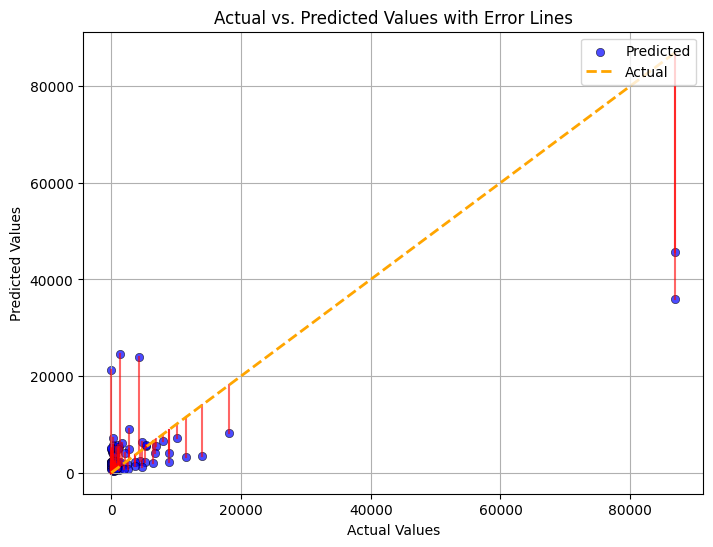

In [11]:
plots = Plots()

print("Plot of Actual vs. Predicted Values Random Forest:")
plots.plot_actual_vs_predicted(y_test, y_pred)

The Scatter plot indicates that the current model not performing well and needs significant improvement. A thorough investigation of the model,data and features is needed to identigy the root causes of the errors and develop a more accurate model.

Residual Analysis Random Forest:


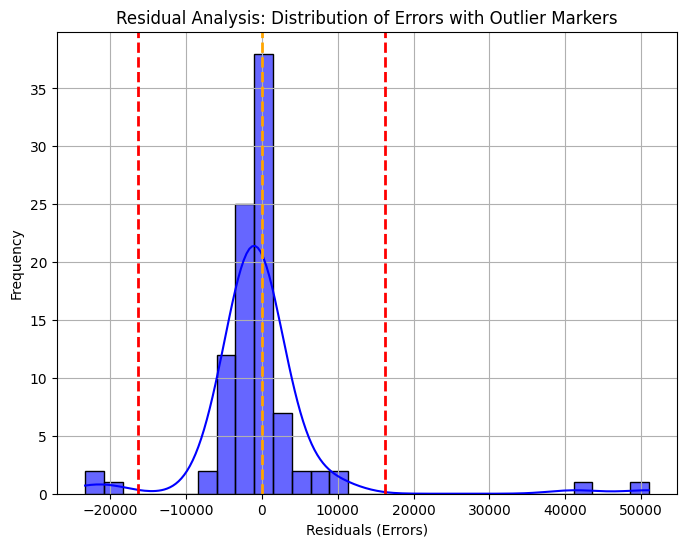

In [12]:
print("Residual Analysis Random Forest:")
plots.plot_residual_analysis(y_test, y_pred)

This histogram shows the distribution of your model's prediction error (residuals).
 - **Centered around zero**: Ideally, the errors should be centered around zero,indicating unbiased predictions.
 - **Skewed Distribution** : The distribution is not perfectly symmentrical. It appears slightly skewed to the right,suggesting a tendency for the model to make larager positive errors (over predictions) more often than larger negative errors (under prediction)
 - **outliers** : The red dashed lines likely represents thresholds for identifying outliers.Data points beyond these lines are coinsdered significant errors.The presence of data points far from the center indicates  that your model has difficulty accurately predicting some data points.
 - **Non-Normal** : The distribution doesn't perfectly follow a normal curve ,which can indicate issues with the model or the data.

In summary, this model has some biases and struggles with certain data points,leading to a skewed error distribution with outliers.

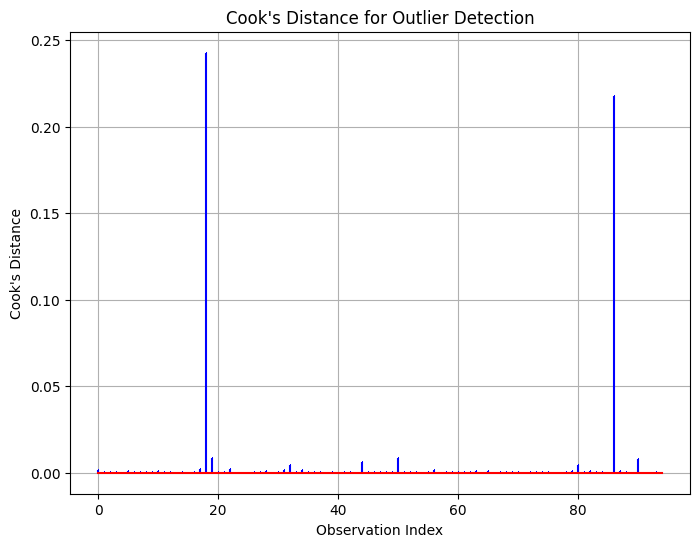

In [16]:
plots.plot_cooks_distance(y_test,y_pred)

This plots shows the **cooks distance** a measure of the influence each data point has on the regression model.
 - **High spikes** : The high spikes indicate data points with large influenc on the nodel. These are potenetial outliers that could disproportionaltely affect the regression results.
 - **Low BaseLine** : Most data points havevery low **Cook's Distance**, meaning they have little impact on the model.
 - **Outlier Concern** The spikes suggest the presence of influential outliers that should be investigated. They may be errors in the data or genuinely important points,but they warrent attention.

In summary,this plot highlights influential outliers that need to be examined to ensure the robustness and reliability of the regression model

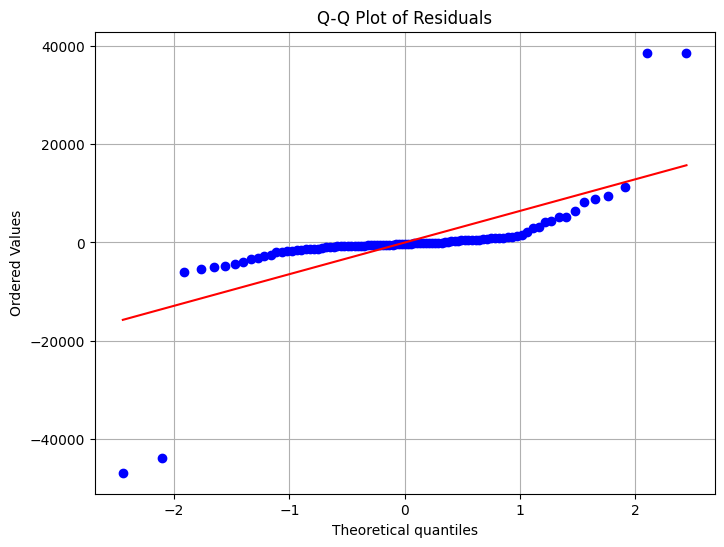

In [17]:
plots.plot_qq_plot(y_test,y_pred)

This is a **Q-Q Plot of residuals**, checking if the errors are normally distributed
 - **Deviation from Line** : The points deviate significantly from the red line ,especislly st the tails. This indicates the residuals are not normally distributed.
 - **Issues** : Non-Normal residuals can violate assumpations of some statistical models,potentially affecting the reliability of our results.

In summary , The Q-Q Plots shows your model's errors are not normally distributed, which is a cause for concern

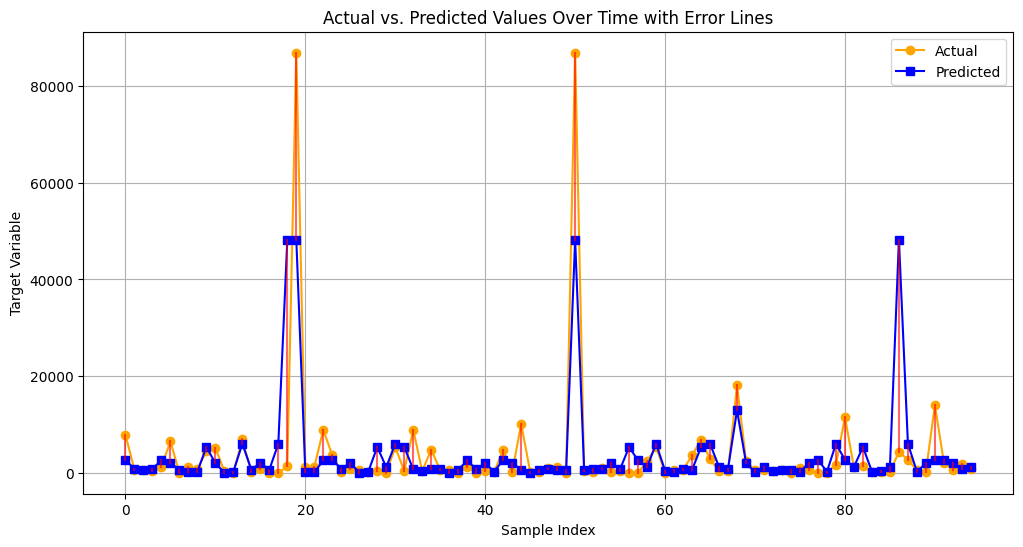

In [18]:
plots.plot_actual_vs_predicted_line(y_test,y_pred)

### Key Observations:
 - **General  Close Fit** : The predicted values follows the actual values reasonably well for the most of the data.
 - **Spikes in Errors**: These are significant spikes in error at certain points, indicating the model struggles with predicting those specific data points.

In summary, the model mostly follows the trend but struggles with certain data oints, leading to significant errors at thise points.


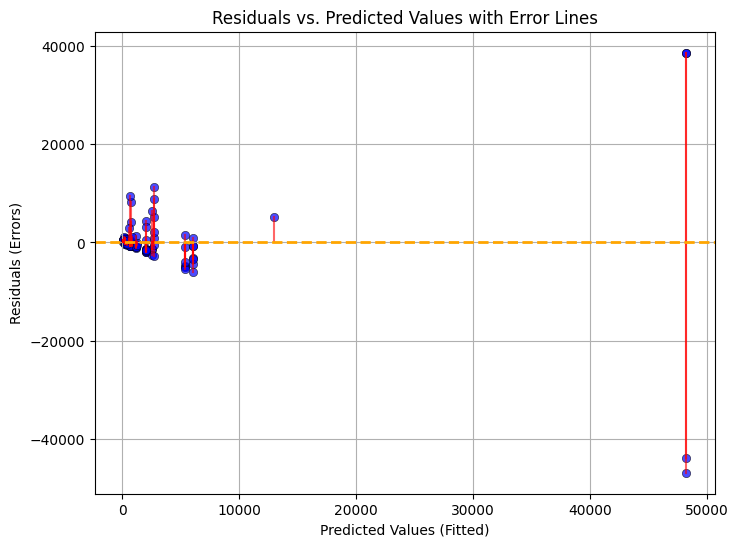

In [20]:
plots.plot_residuals_vs_fitted(y_test,y_pred)

### Key observation:
 - **Horizontal Line at zero** : Idellay , the residuals should be randomly scattered around this line, indicating no pattern
 - **Funnel Shape** : The residuals shows a funnel shape, spreading out as predicted values increase.This suggests **heteroscedasticity** , meaning the error araiance is not constant.

In summary , The graph revelas heteroscedasticity and outliers, suggesting your model's error variance is not consistent and it struggles  with certain data points.

# Decision Tree Implementation

In [21]:
# Decision Tree
def objective_dt(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10)
    }
    model = DecisionTreeRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)
study = optuna.create_study(direction='maximize')
study.optimize(objective_dt, n_trials=30)
print("Best Optuna params:", study.best_params)

[I 2025-03-14 15:04:00,688] A new study created in memory with name: no-name-8f663fcc-831b-4188-b4c8-9623ee3226b3
[I 2025-03-14 15:04:00,725] Trial 0 finished with value: -0.8585097377643884 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 0 with value: -0.8585097377643884.
[I 2025-03-14 15:04:00,749] Trial 1 finished with value: 0.22168144699734238 and parameters: {'max_depth': 23, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.22168144699734238.
[I 2025-03-14 15:04:00,781] Trial 2 finished with value: -0.7612308898779827 and parameters: {'max_depth': 39, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.22168144699734238.
[I 2025-03-14 15:04:00,790] Trial 3 finished with value: 0.43990884951461817 and parameters: {'max_depth': 3, 'min_samples_split': 11, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.43990884951461817.
[I 2025-03-14 15:04:00,810] Trial 4 finished with val

Best Optuna params: {'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 10}


In [22]:
model = DecisionTreeRegressor(**study.best_params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae}, RMSE: {rmse}, R2: {r2}')

MAE: 3365.076180599762, RMSE: 9096.017173311286, R2: 0.47968478847327756


## Interpretation of Decision Tree Regressor Results  

### 1. Model Performance  
The **Decision Tree Regressor** was optimized using **Optuna**, with the best hyperparameters:  
- max_depth: **4**  
- min_samples_split: **20**  
- min_samples_leaf: **10**  

Evaluated **metrics**:  
- **MAE**:  **3365.08** (Average absolute error between actual and predicted values)  
- **RMSE**: **9096.02** (Higher error variance, indicating large deviations in some predictions)  
- **R² Score**: **0.4797** (Explains **47.97%** of variance, leaving significant room for improvement)  

### 2. Interpretation & Next Steps  
- The model has a **low R² score**, meaning it does not capture patterns effectively.  
- The **RMSE is high**, suggesting some large prediction errors.  
- **Shallow depth (max_depth=4)** may lead to underfitting.  

#### **Ways to Improve**:  
- **Increase `max_depth`** to allow deeper trees to capture more patterns.  
- **Try ensemble methods** like **Random Forest** or **Gradient Boosting** for better generalization.  
- **Feature engineering** to provide better input variables.  


Plot of Actual vs. Predicted Values Decision Tree:


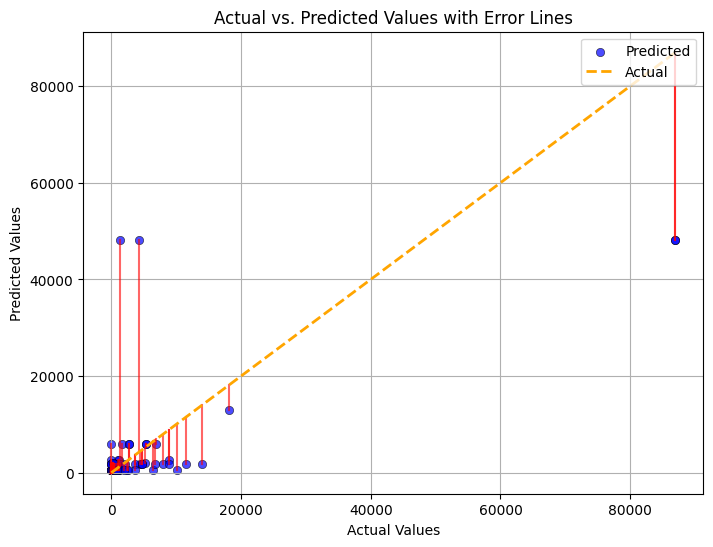

In [23]:
print("Plot of Actual vs. Predicted Values Decision Tree:")
plots.plot_actual_vs_predicted(y_test, y_pred)

The Scatter plot indicates that the current model not performing well and needs significant improvement. A thorough investigation of the model,data and features is needed to identigy the root causes of the errors and develop a more accurate model.

Residual plot Analysis for Decision Tree


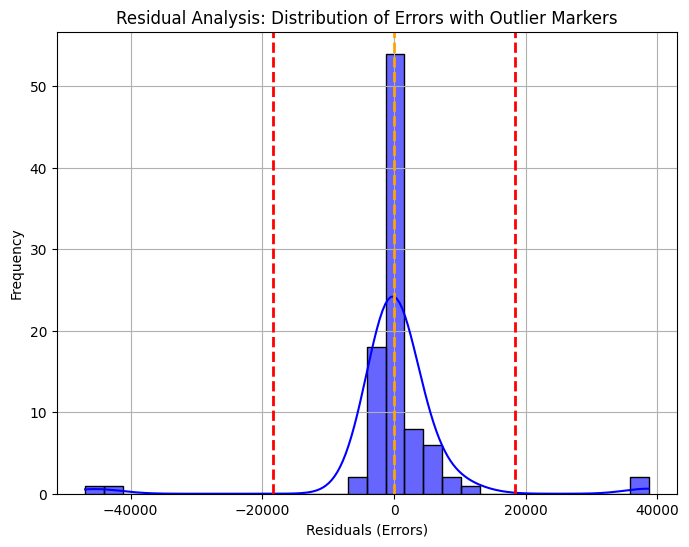

In [24]:
print("Residual plot Analysis for Decision Tree")
plots.plot_residual_analysis(y_test, y_pred)

This histogram shows the distribution of your model's prediction error (residuals).
 - **Centered around zero**: Ideally, the errors should be centered around zero,indicating unbiased predictions.
 - **Skewed Distribution** : The distribution is not perfectly symmentrical. It appears slightly skewed to the right,suggesting a tendency for the model to make larager positive errors (over predictions) more often than larger negative errors (under prediction)
 - **outliers** : The red dashed lines likely represents thresholds for identifying outliers.Data points beyond these lines are coinsdered significant errors.The presence of data points far from the center indicates  that your model has difficulty accurately predicting some data points.
 - **Non-Normal** : The distribution doesn't perfectly follow a normal curve ,which can indicate issues with the model or the data.

In summary, this model has some biases and struggles with certain data points,leading to a skewed error distribution with outliers.

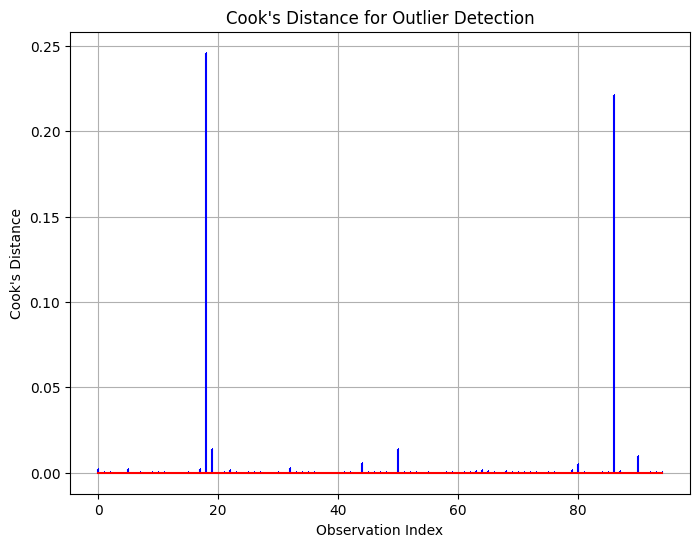

In [25]:
plots.plot_cooks_distance(y_test,y_pred)

This plots shows the **cooks distance** a measure of the influence each data point has on the regression model.
 - **High spikes** : The high spikes indicate data points with large influenc on the nodel. These are potenetial outliers that could disproportionaltely affect the regression results.
 - **Low BaseLine** : Most data points havevery low **Cook's Distance**, meaning they have little impact on the model.
 - **Outlier Concern** The spikes suggest the presence of influential outliers that should be investigated. They may be errors in the data or genuinely important points,but they warrent attention.

In summary,this plot highlights influential outliers that need to be examined to ensure the robustness and reliability of the regression model

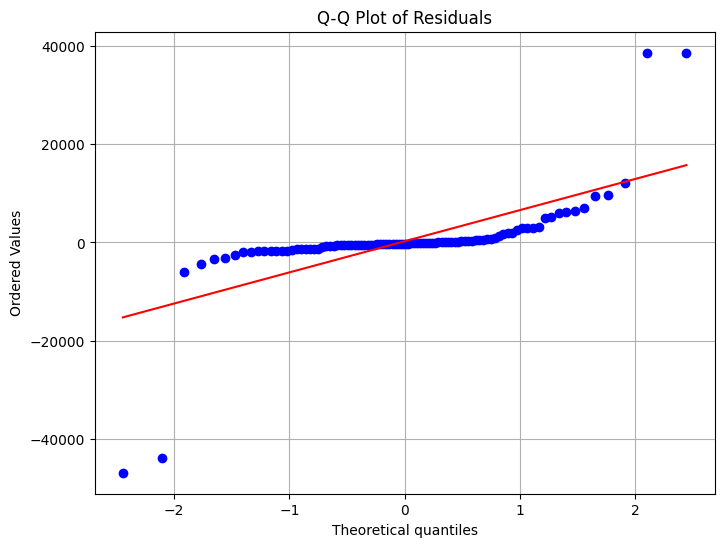

In [26]:
plots.plot_qq_plot(y_test,y_pred)

This is a **Q-Q Plot of residuals**, checking if the errors are normally distributed
 - **Deviation from Line** : The points deviate significantly from the red line ,especislly st the tails. This indicates the residuals are not normally distributed.
 - **Issues** : Non-Normal residuals can violate assumpations of some statistical models,potentially affecting the reliability of our results.

In summary , The Q-Q Plots shows your model's errors are not normally distributed, which is a cause for concern

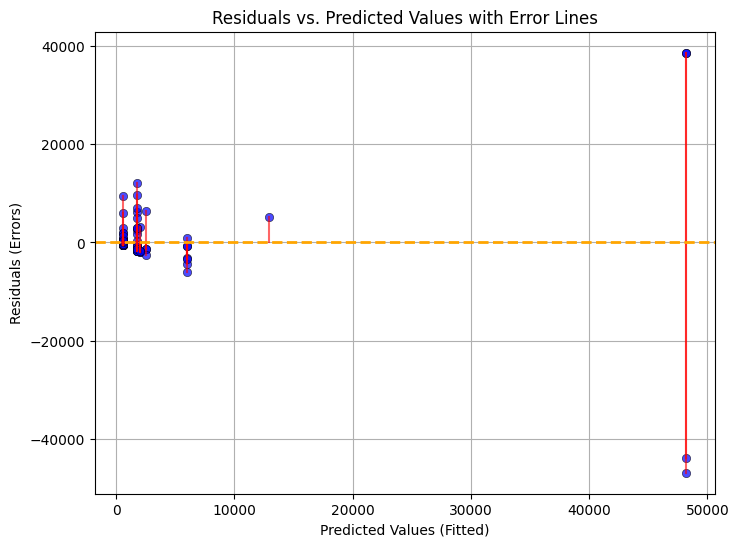

In [27]:
plots.plot_residuals_vs_fitted(y_test,y_pred)

### Key observation:
 - **Horizontal Line at zero** : Idellay , the residuals should be randomly scattered around this line, indicating no pattern
 - **Funnel Shape** : The residuals shows a funnel shape, spreading out as predicted values increase.This suggests **heteroscedasticity** , meaning the error araiance is not constant.

In summary , The graph revelas heteroscedasticity and outliers, suggesting your model's error variance is not consistent and it struggles  with certain data points.

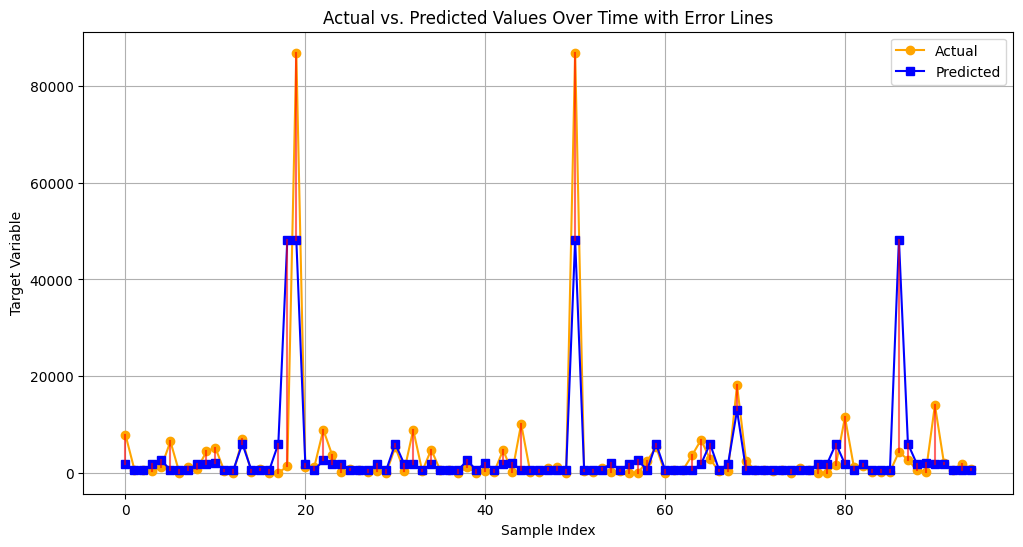

In [28]:
plots.plot_actual_vs_predicted_line(y_test,y_pred)

### Key Observations:
 - **General  Close Fit** : The predicted values follows the actual values reasonably well for the most of the data.
 - **Spikes in Errors**: These are significant spikes in error at certain points, indicating the model struggles with predicting those specific data points.

In summary, the model mostly follows the trend but struggles with certain data oints, leading to significant errors at thise points.


# SVM Implementation

In [29]:
from sklearn.svm import SVR
def objective_svm(trial):
    params = {
        'C': trial.suggest_float('C', 0.1, 100.0),
        'epsilon': trial.suggest_float('epsilon', 0.01, 1.0),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
        'degree': trial.suggest_int('degree', 2, 5),
        'gamma': trial.suggest_categorical('gamma', ['scale', 'auto']),
        'epsilon': trial.suggest_float('epsilon', 0.01, 1.0),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    }
    model = SVR(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective_svm, n_trials=30)
print("Best Optuna params:", study.best_params)



[I 2025-03-14 15:05:54,866] A new study created in memory with name: no-name-192667f8-23eb-4cd9-bd61-9c975fa5df53
[I 2025-03-14 15:05:54,898] Trial 0 finished with value: -0.0513821605056306 and parameters: {'C': 18.922916033711786, 'epsilon': 0.8602296060697447, 'kernel': 'sigmoid', 'degree': 4, 'gamma': 'auto'}. Best is trial 0 with value: -0.0513821605056306.
[I 2025-03-14 15:05:54,934] Trial 1 finished with value: 0.1287834847847178 and parameters: {'C': 38.87972244088773, 'epsilon': 0.14087753657680543, 'kernel': 'linear', 'degree': 4, 'gamma': 'auto'}. Best is trial 1 with value: 0.1287834847847178.
[I 2025-03-14 15:05:54,981] Trial 2 finished with value: 0.12419426627262531 and parameters: {'C': 55.96832257116084, 'epsilon': 0.3021423481376891, 'kernel': 'linear', 'degree': 2, 'gamma': 'auto'}. Best is trial 1 with value: 0.1287834847847178.
[I 2025-03-14 15:05:56,622] Trial 3 finished with value: 0.24764494507184764 and parameters: {'C': 95.45003316627712, 'epsilon': 0.19063278

Best Optuna params: {'C': 50.964348261691974, 'epsilon': 0.031117781506297182, 'kernel': 'poly', 'degree': 4, 'gamma': 'auto'}


In [30]:
model = SVR(**study.best_params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae}, RMSE: {rmse}, R2: {r2}')

MAE: 3462.126671496736, RMSE: 6462.756060523304, R2: 0.7373366332000422


## Interpretation of Support Vector Machine (SVM) Regressor Results  

### 1. Model Performance  
The **SVM Regressor** was optimized using **Optuna**, with the best hyperparameters:  
- C: **50.96** (High regularization strength)  
- epsilon: **0.0311** (Small margin for error)  
- kernel: **poly** (Polynomial kernel)  
- degree: **4** (Higher-degree polynomial for capturing complex relationships)  
- gamma: **auto** (Automatically computed kernel coefficient)  

Evaluated **metrics**:  
- **MAE**:  **3462.13** (Average absolute error between actual and predicted values)  
- **RMSE**: **6462.76** (Moderate error variance)  
- **R² Score**: **0.7373** (Explains **73.73%** of variance, indicating a well-fitted model)  

### 2. Interpretation & Next Steps  
- The **high R² score** suggests that the model captures a significant portion of the data’s variability.  
- **RMSE is relatively lower** than previous models, meaning fewer large errors.  
- **Polynomial kernel (`degree=4`)** may be overfitting; testing lower degrees (e.g., **2 or 3**) could improve generalization.  

#### **Ways to Improve**:  
- **Tune `C` and `epsilon`** further to balance bias-variance trade-off.  
- **Experiment with different kernels** (e.g., **RBF**) to compare performance.  
- **Feature scaling and selection** to improve computational efficiency and model accuracy.  


Plot of Actual vs. Predicted Values Support Vector Machine:


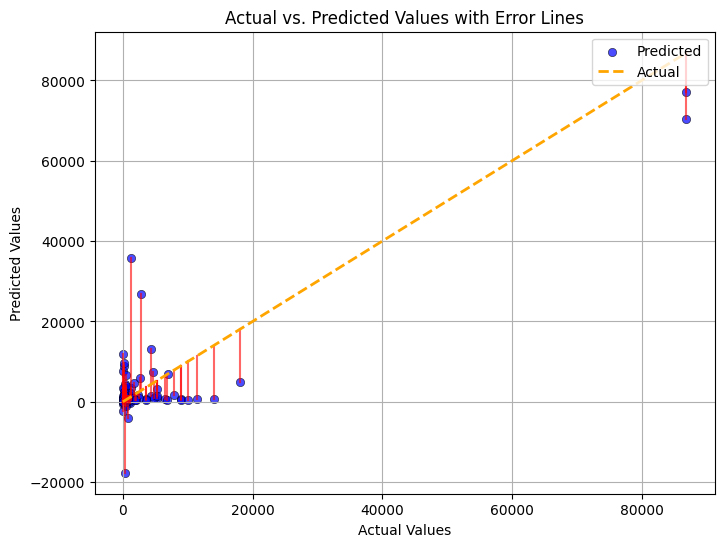

In [31]:
print("Plot of Actual vs. Predicted Values Support Vector Machine:")
plots.plot_actual_vs_predicted(y_test, y_pred)

### Key observation

from the graph , it shows that the SVM model is **underfitting** the data and needs significant improvement.Focus on the tuning hyperparameters,data preprocessing to enhnace the model performanace.

Residual plot Analysis for Support Vector Machine


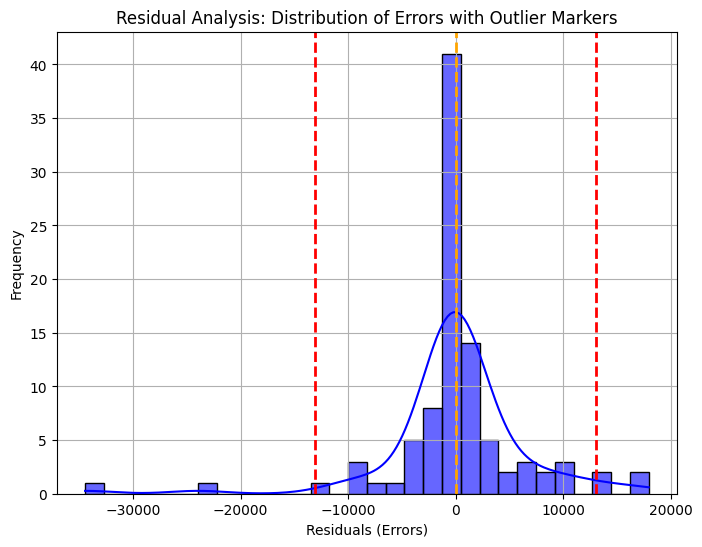

In [32]:
print("Residual plot Analysis for Support Vector Machine")
plots.plot_residual_analysis(y_test, y_pred)

This histogram shows the distribution of your model's prediction error (residuals).
 - **Centered around zero**: Ideally, the errors should be centered around zero,indicating unbiased predictions.
 - **Skewed Distribution** : The distribution is not perfectly symmentrical. It appears slightly skewed to the right,suggesting a tendency for the model to make larager positive errors (over predictions) more often than larger negative errors (under prediction)
 - **outliers** : The red dashed lines likely represents thresholds for identifying outliers.Data points beyond these lines are coinsdered significant errors.The presence of data points far from the center indicates  that your model has difficulty accurately predicting some data points.
 - **Non-Normal** : The distribution doesn't perfectly follow a normal curve ,which can indicate issues with the model or the data.

In summary, this model has some biases and struggles with certain data points,leading to a skewed error distribution with outliers.

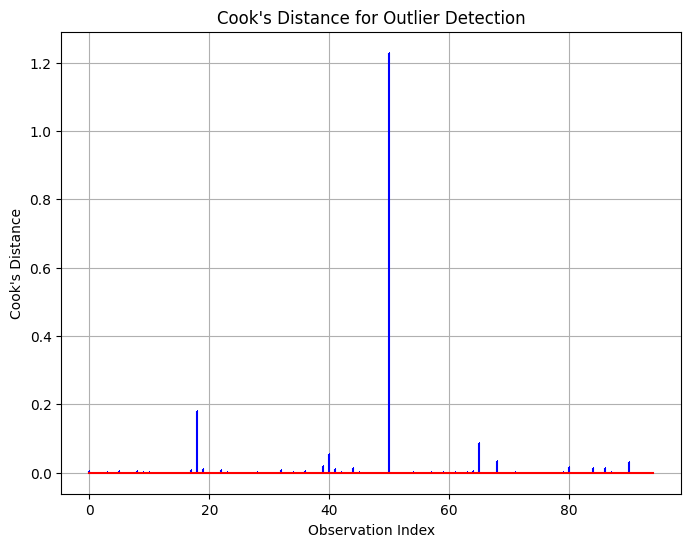

In [33]:
plots.plot_cooks_distance(y_test,y_pred)

This plots shows the **cooks distance** a measure of the influence each data point has on the regression model.
 - **High spikes** : The high spikes indicate data points with large influenc on the nodel. These are potenetial outliers that could disproportionaltely affect the regression results.
 - **Low BaseLine** : Most data points havevery low **Cook's Distance**, meaning they have little impact on the model.
 - **Outlier Concern** The spikes suggest the presence of influential outliers that should be investigated. They may be errors in the data or genuinely important points,but they warrent attention.

In summary,this plot highlights influential outliers that need to be examined to ensure the robustness and reliability of the regression model

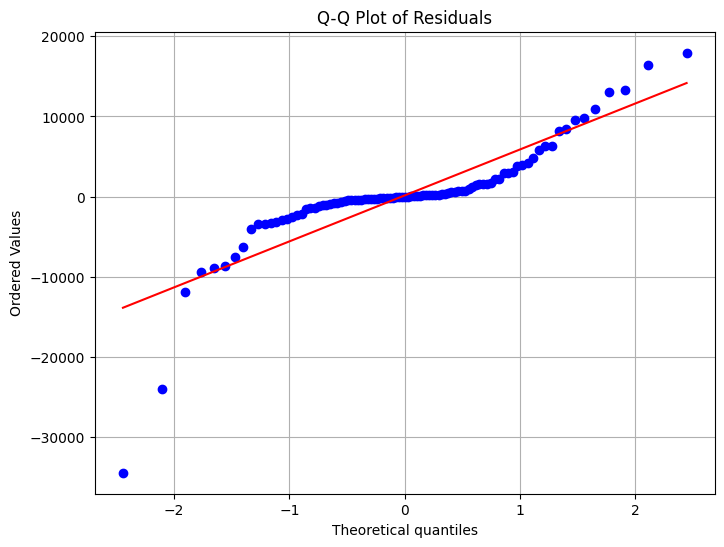

In [34]:
plots.plot_qq_plot(y_test,y_pred)

This is a **Q-Q Plot of residuals**, checking if the errors are normally distributed
 - **Deviation from Line** : The points deviate significantly from the red line ,especislly st the tails. This indicates the residuals are not normally distributed.
 - **Issues** : Non-Normal residuals can violate assumpations of some statistical models,potentially affecting the reliability of our results.

In summary , The Q-Q Plots shows your model's errors are not normally distributed, which is a cause for concern

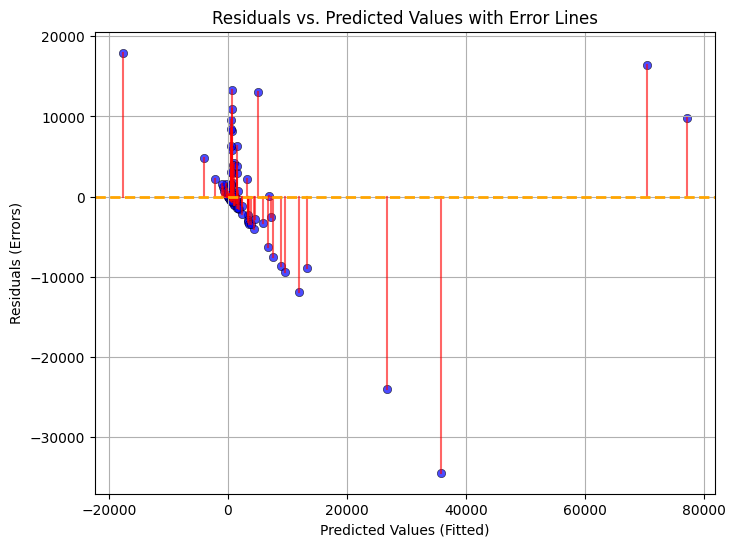

In [35]:
plots.plot_residuals_vs_fitted(y_test,y_pred)

### Key observation:
 - **Horizontal Line at zero** : Idellay , the residuals should be randomly scattered around this line, indicating no pattern
 - **Funnel Shape** : The residuals shows a funnel shape, spreading out as predicted values increase.This suggests **heteroscedasticity** , meaning the error araiance is not constant.

In summary , The graph revelas heteroscedasticity and outliers, suggesting your model's error variance is not consistent and it struggles  with certain data points.

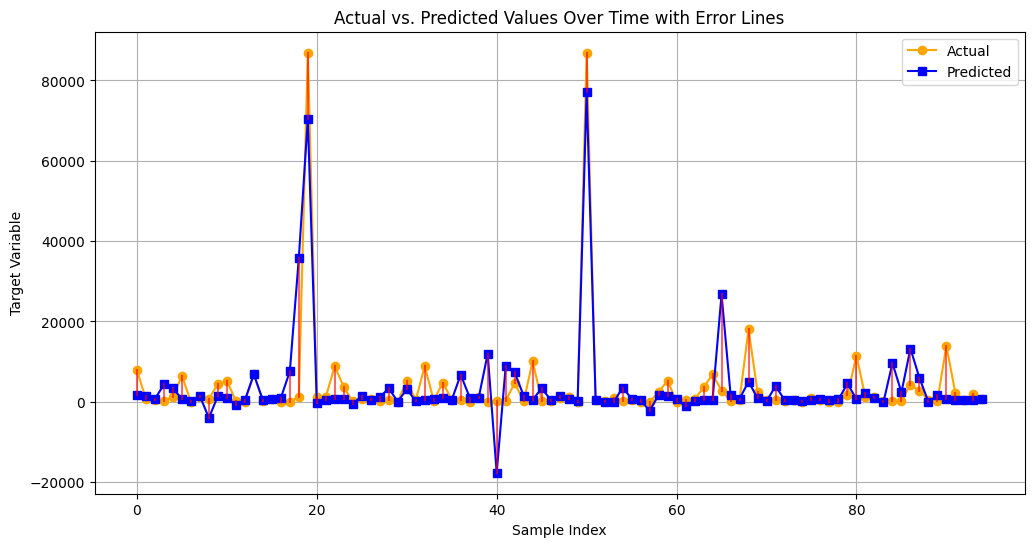

In [36]:
plots.plot_actual_vs_predicted_line(y_test,y_pred)

### Key observation:
 - **Horizontal Line at zero** : Idellay , the residuals should be randomly scattered around this line, indicating no pattern
 - **Funnel Shape** : The residuals shows a funnel shape, spreading out as predicted values increase.This suggests **heteroscedasticity** , meaning the error araiance is not constant.

In summary , The graph revelas heteroscedasticity and outliers, suggesting your model's error variance is not consistent and it struggles  with certain data points.

# XGBoost Implementation

In [37]:
from xgboost import XGBRegressor
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 50),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),  # Added correct param
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),  # Regularization
        'lambda': trial.suggest_float('lambda', 0.0, 10.0)  # L2 Regularization
    }
    model = XGBRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective_xgb, n_trials=30)
print("Best Optuna params:", study.best_params)




[I 2025-03-14 15:09:28,366] A new study created in memory with name: no-name-00c91ee9-0683-489a-b75a-1673d1615d39
[I 2025-03-14 15:09:34,886] Trial 0 finished with value: 0.6855463337673049 and parameters: {'n_estimators': 452, 'max_depth': 39, 'learning_rate': 0.1896449857716511, 'subsample': 0.8943414499585383, 'colsample_bytree': 0.7940263599355123, 'gamma': 1.3175631649707742, 'lambda': 6.017074950764441}. Best is trial 0 with value: 0.6855463337673049.
[I 2025-03-14 15:09:40,410] Trial 1 finished with value: 0.5856127068128604 and parameters: {'n_estimators': 147, 'max_depth': 16, 'learning_rate': 0.02899470061973878, 'subsample': 0.7440506143881241, 'colsample_bytree': 0.9444163688466893, 'gamma': 2.8377112684657457, 'lambda': 0.9466387667341791}. Best is trial 0 with value: 0.6855463337673049.
[I 2025-03-14 15:09:47,831] Trial 2 finished with value: 0.6234219021347244 and parameters: {'n_estimators': 251, 'max_depth': 42, 'learning_rate': 0.13293681543039004, 'subsample': 0.6841

Best Optuna params: {'n_estimators': 205, 'max_depth': 37, 'learning_rate': 0.0172051627255684, 'subsample': 0.913013805691449, 'colsample_bytree': 0.8357598551104425, 'gamma': 1.723489122842062, 'lambda': 6.96644171081535}


In [38]:
model = XGBRegressor(**study.best_params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae}, RMSE: {rmse}, R2: {r2}')

MAE: 2867.8926482351203, RMSE: 6757.864623169374, R2: 0.7128009793876968


Plot of Actual vs. Predicted Values XGBoost:


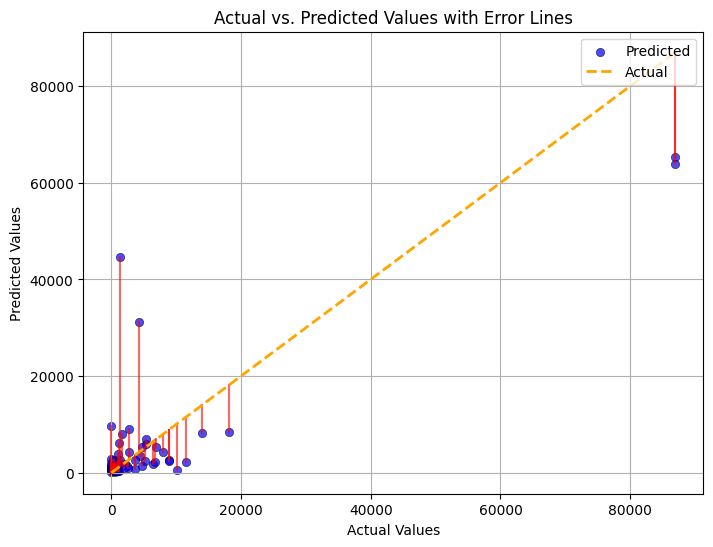

In [39]:
print("Plot of Actual vs. Predicted Values XGBoost:")
plots.plot_actual_vs_predicted(y_test, y_pred)

Residual plot Analysis for XGBoost


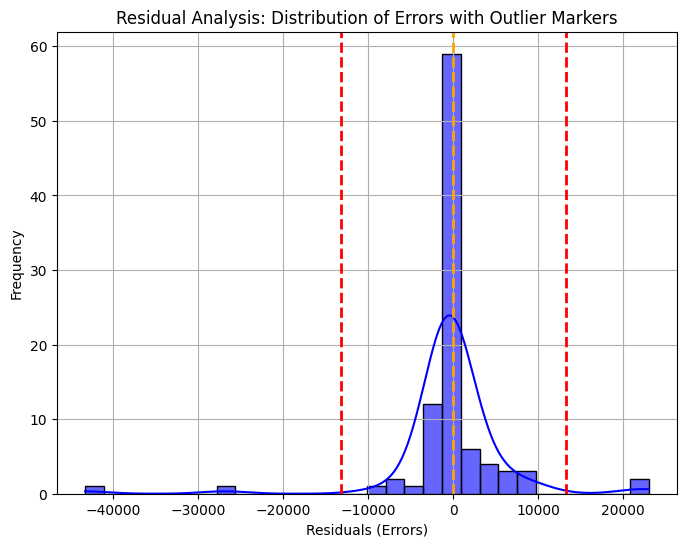

In [40]:
print("Residual plot Analysis for XGBoost")
plots.plot_residual_analysis(y_test, y_pred)

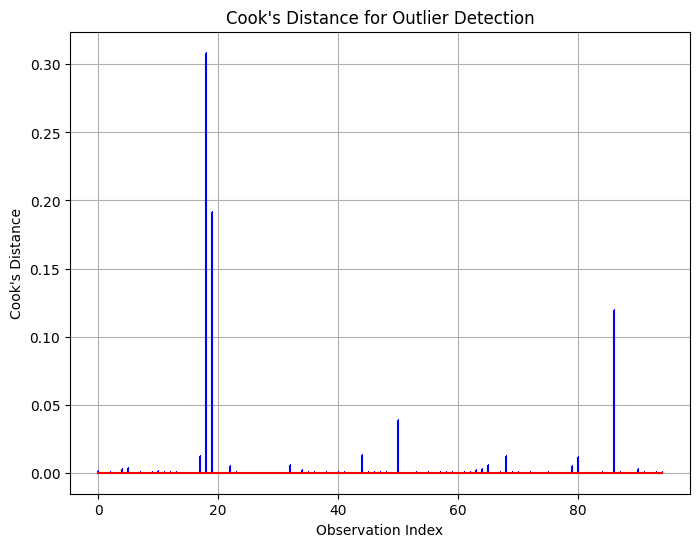

In [41]:
plots.plot_cooks_distance(y_test,y_pred)


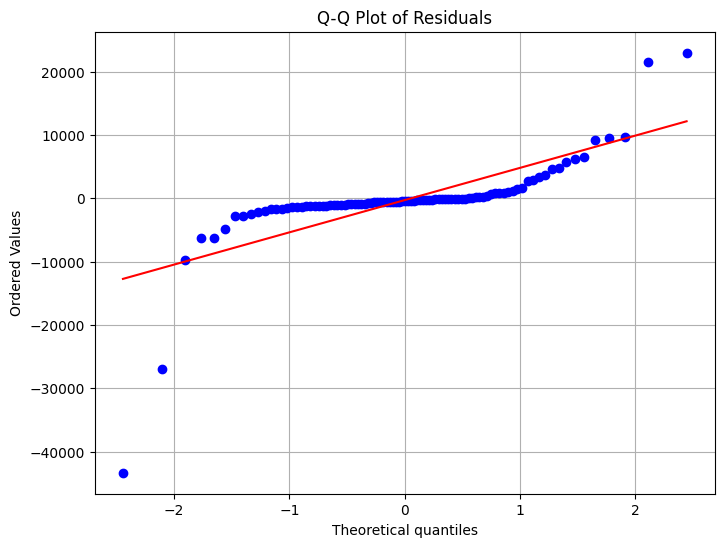

In [42]:
plots.plot_qq_plot(y_test,y_pred)

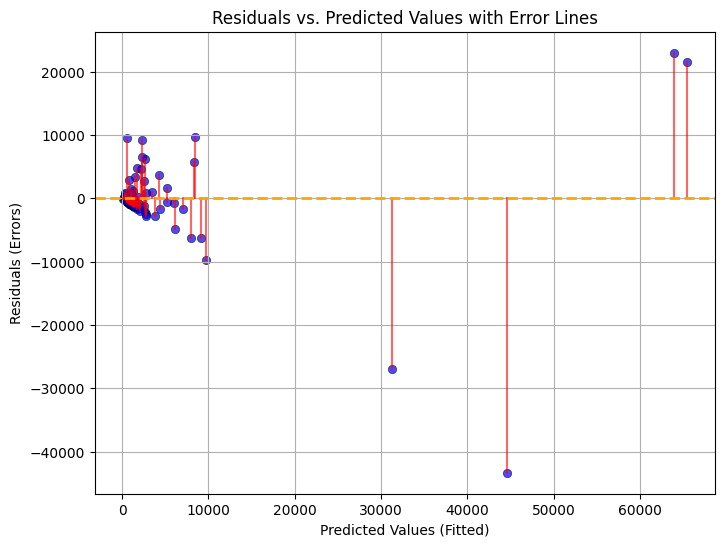

In [43]:
plots.plot_residuals_vs_fitted(y_test,y_pred)

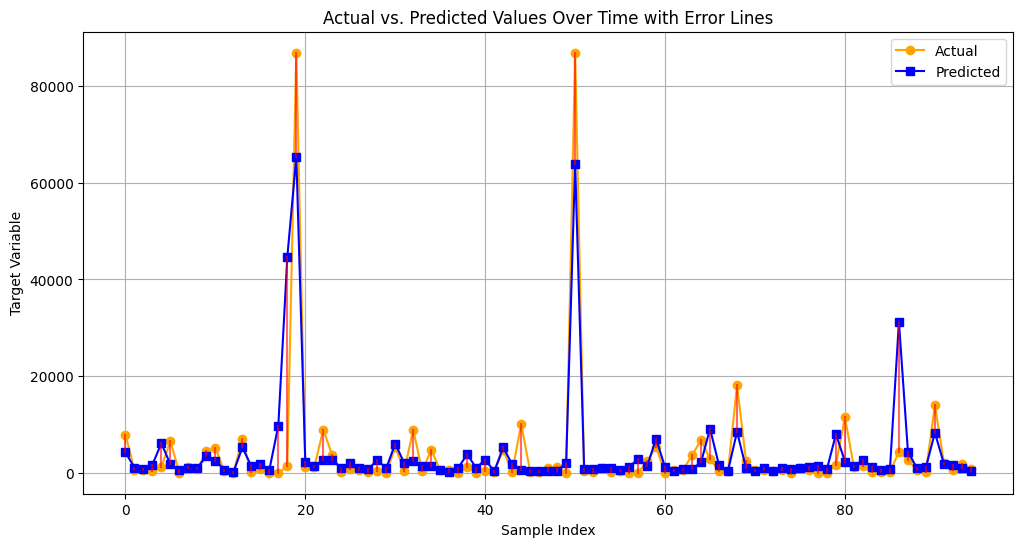

In [44]:
plots.plot_actual_vs_predicted_line(y_test,y_pred)

### Gradient Boosting Implementation

In [45]:
# Gradient Boosting
def objective_gb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3)
    }
    model = GradientBoostingRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective_gb, n_trials=30)
print("Best Optuna params:", study.best_params)




[I 2025-03-14 15:14:54,355] A new study created in memory with name: no-name-79ce3e2d-1b16-437a-9735-2d3c55b326be
[I 2025-03-14 15:14:56,197] Trial 0 finished with value: 0.4481526090345985 and parameters: {'n_estimators': 87, 'max_depth': 39, 'min_samples_split': 6, 'min_samples_leaf': 10, 'learning_rate': 0.23658691721787867}. Best is trial 0 with value: 0.4481526090345985.
[I 2025-03-14 15:14:59,728] Trial 1 finished with value: 0.2210089066537818 and parameters: {'n_estimators': 388, 'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 1, 'learning_rate': 0.19230911723008662}. Best is trial 0 with value: 0.4481526090345985.
[I 2025-03-14 15:15:05,288] Trial 2 finished with value: 0.4711557231290846 and parameters: {'n_estimators': 308, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 2, 'learning_rate': 0.21838004754315077}. Best is trial 2 with value: 0.4711557231290846.
[I 2025-03-14 15:15:08,074] Trial 3 finished with value: 0.6090549799623601 and parameters:

Best Optuna params: {'n_estimators': 180, 'max_depth': 14, 'min_samples_split': 12, 'min_samples_leaf': 2, 'learning_rate': 0.12649460621401645}


In [46]:
model = GradientBoostingRegressor(**study.best_params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae}, RMSE: {rmse}, R2: {r2}')

MAE: 2519.6923976038793, RMSE: 5544.741111115104, R2: 0.8066578577802053


Plot of Actual vs. Predicted Values Gradient Boosting:


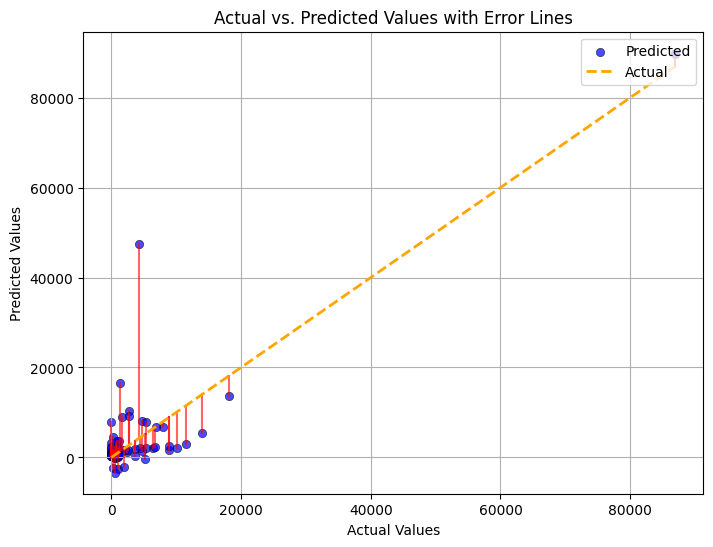

In [47]:
print("Plot of Actual vs. Predicted Values Gradient Boosting:")
plots.plot_actual_vs_predicted(y_test, y_pred)

Residual plot Analysis for Gradient Boosting


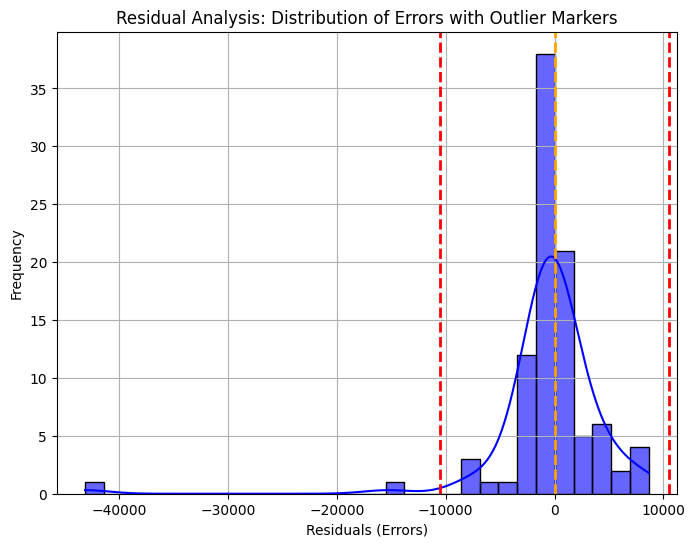

In [48]:
print("Residual plot Analysis for Gradient Boosting")
plots.plot_residual_analysis(y_test, y_pred)

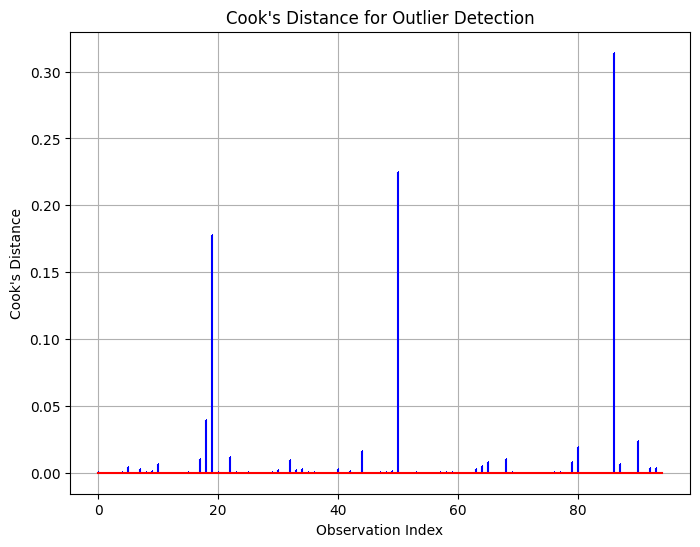

In [49]:
plots.plot_cooks_distance(y_test,y_pred)

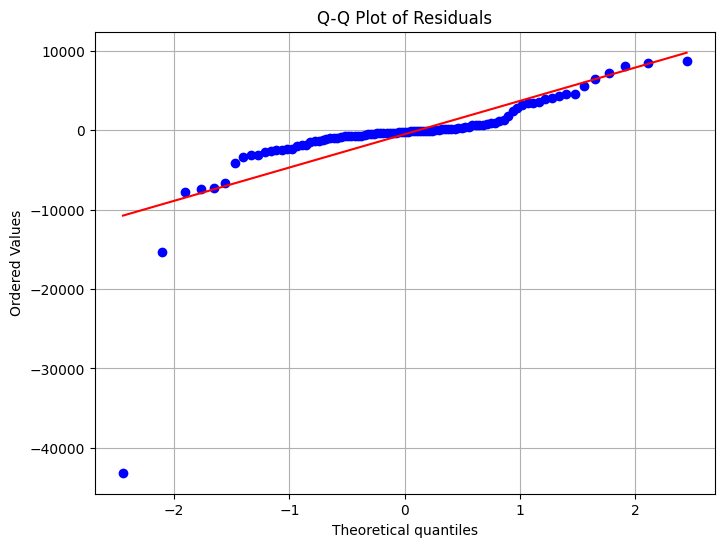

In [50]:
plots.plot_qq_plot(y_test,y_pred)

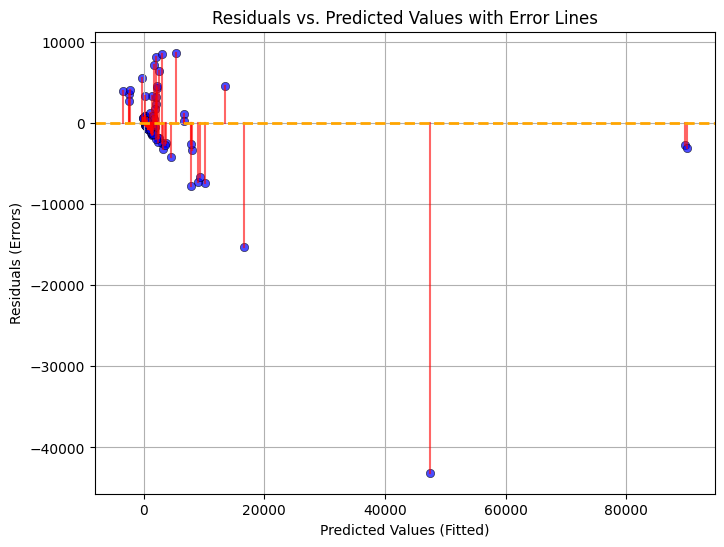

In [52]:
plots.plot_residuals_vs_fitted(y_test,y_pred)

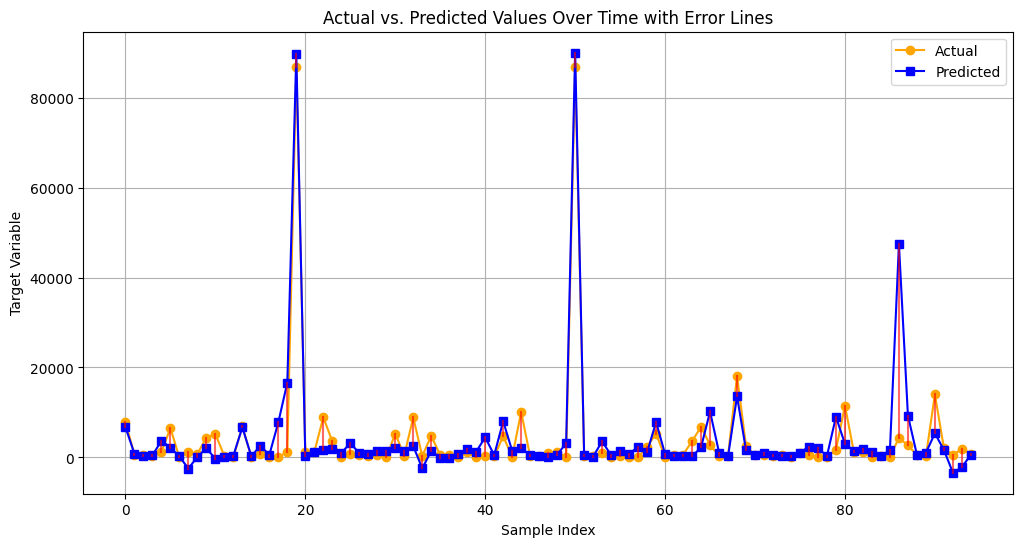

In [53]:
plots.plot_actual_vs_predicted_line(y_test,y_pred)

### AdaBoost Implementation

In [54]:
def objective_ab(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'estimator': DecisionTreeRegressor()
    }
    
    model = AdaBoostRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)



study = optuna.create_study(direction='maximize')
study.optimize(objective_ab, n_trials=30)
print("Best Optuna params:", study.best_params)



[I 2025-03-14 15:20:39,670] A new study created in memory with name: no-name-dd466fc7-db26-4697-b749-a876c20436aa
[I 2025-03-14 15:20:43,136] Trial 0 finished with value: 0.7650744672974236 and parameters: {'n_estimators': 245, 'learning_rate': 0.6286645692270514}. Best is trial 0 with value: 0.7650744672974236.
[I 2025-03-14 15:20:45,435] Trial 1 finished with value: 0.8351031438195661 and parameters: {'n_estimators': 215, 'learning_rate': 0.8864012345805996}. Best is trial 1 with value: 0.8351031438195661.
[I 2025-03-14 15:20:46,827] Trial 2 finished with value: 0.7668661317180908 and parameters: {'n_estimators': 91, 'learning_rate': 0.6483688219967939}. Best is trial 1 with value: 0.8351031438195661.
[I 2025-03-14 15:20:51,567] Trial 3 finished with value: 0.7667862406279815 and parameters: {'n_estimators': 234, 'learning_rate': 0.4505522926645258}. Best is trial 1 with value: 0.8351031438195661.
[I 2025-03-14 15:21:00,953] Trial 4 finished with value: 0.7655431972451028 and paramet

Best Optuna params: {'n_estimators': 352, 'learning_rate': 0.966708283363923}


In [56]:
model = AdaBoostRegressor(n_estimators = 352, learning_rate=0.966708283363923)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae}, RMSE: {rmse}, R2: {r2}')

MAE: 2980.273252080889, RMSE: 5771.006602315839, R2: 0.7905563866205166


Plot of Actual vs. Predicted Values AdaBoost:


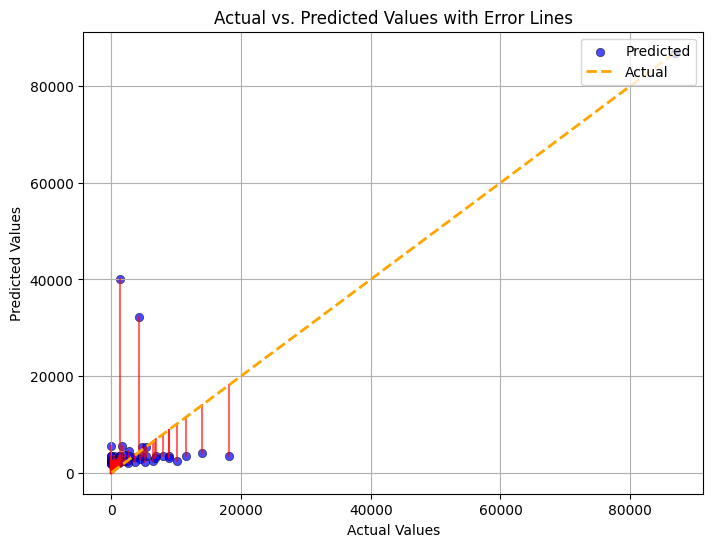

In [57]:
print("Plot of Actual vs. Predicted Values AdaBoost:")
plots.plot_actual_vs_predicted(y_test, y_pred)

Residual plot Analysis for AdaBoost


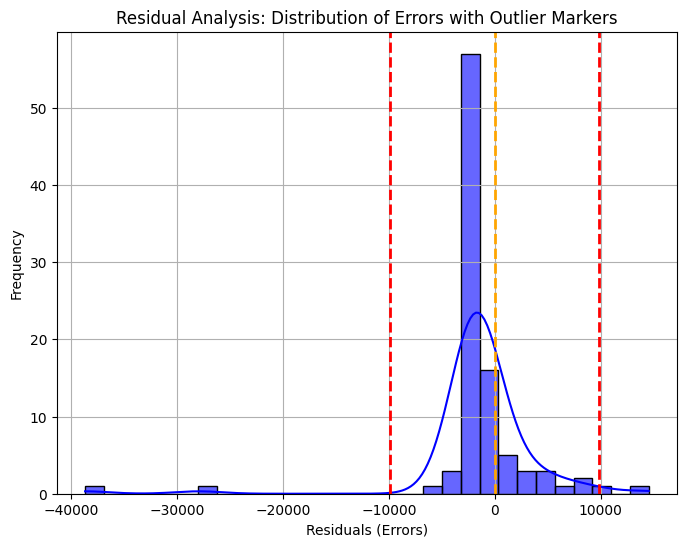

In [58]:
print("Residual plot Analysis for AdaBoost")
plots.plot_residual_analysis(y_test, y_pred)

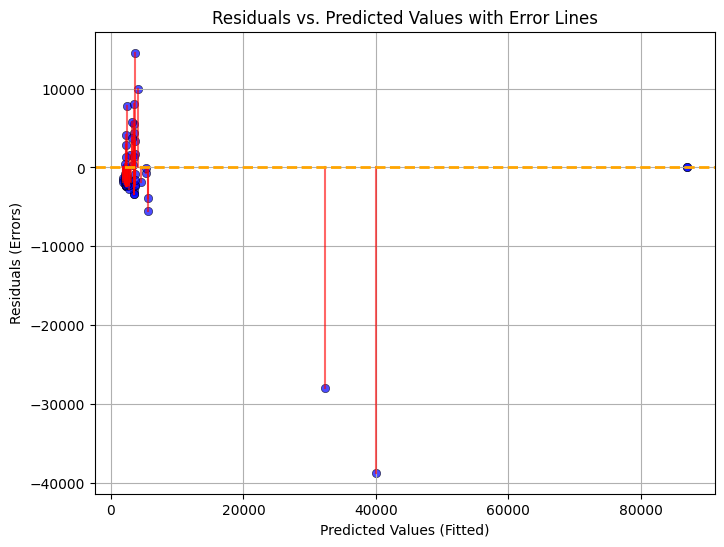

In [59]:


plots.plot_residuals_vs_fitted(y_test,y_pred)

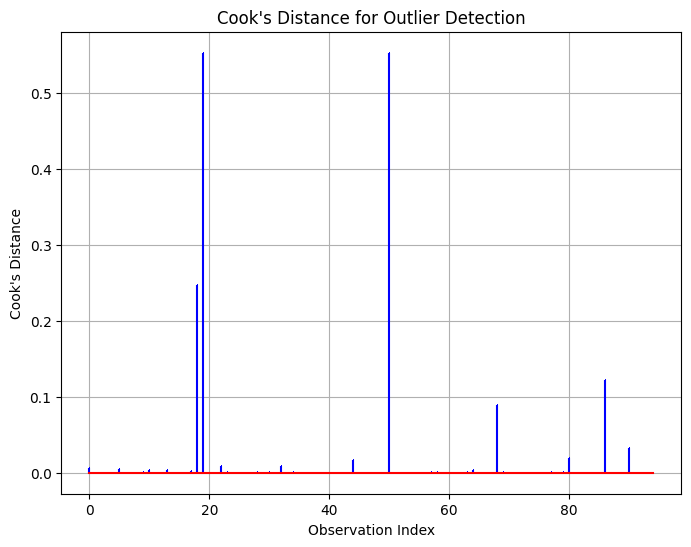

In [60]:
plots.plot_cooks_distance(y_test,y_pred)

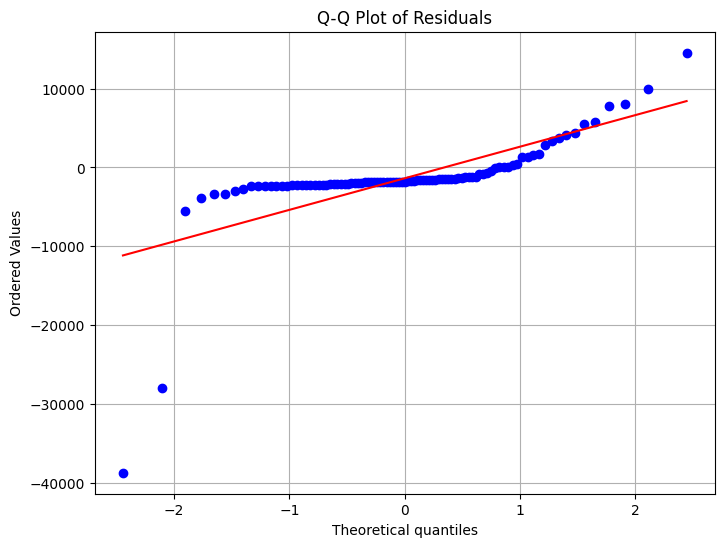

In [61]:
plots.plot_qq_plot(y_test,y_pred)

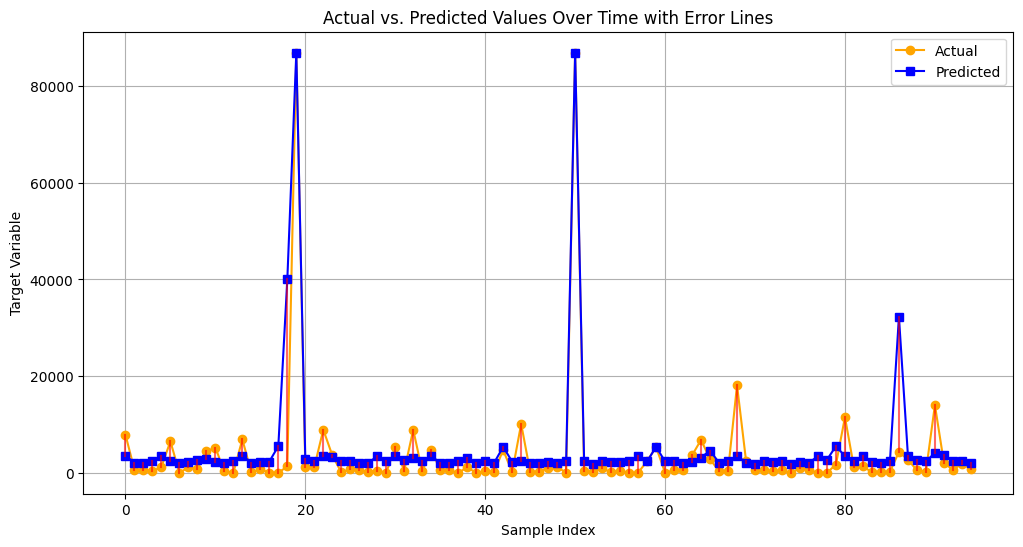

In [62]:
plots.plot_actual_vs_predicted_line(y_test,y_pred)

# TSNE Implementation

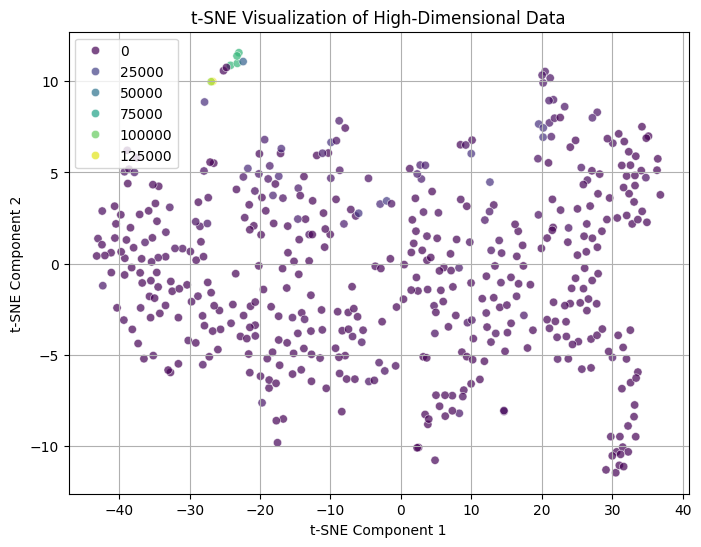

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Convert high-dimensional dataset into 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X)  # Apply t-SNE on full dataset


